# What is this page?

This is a Jupyter notebook currently running in a virtual machine (a "binder"). You can edit any cell and run it by clicking on the Run button above or hitting Shift-Enter (you will need to start from the top and run all cells the first time round). Any changes you make will be lost when you close this window or let it time out and the virtual machine is mopped up. However, you can save a local copy of this notebook including any changes to your machine by using the menu (File > Download as > Notebook). This notebook resides in a [git repository](https://bitbucket.org/fsmeraldi/regressionleakage) on Bitbucket. If you are familiar with git and have a Bitbucket account, I can add your user to the repository and we can use it to exchange information.

In [1]:
# libraries and settings
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Attack against a linear regression node

We simulate an attack on the node by diagonalising the correlation matrix of the data held by the node. The attacker can do this by gradient ascent on the even part of the residue, as described in the notes we exchanged.

We work in the limit of a high number of features and low number of patients. 500 features is not unrealistic if you have, for instance, gene expression data.

In [2]:
npatients=5
nfeatures=500 # lowering dimensionality will make it harder to reconstruct the data

Let's generate some random data. Scaling is to ensure that the Eigenvalues of the correlation matrix ```C``` are sufficiently spaced. If the standard deviation is reduced or the scaling operation is commented out altogether, the precision of the estimate decreases. If all data are normalised, no estimate is possible (the Eigenvalues of ```C``` are degenerate).

In [3]:
X=np.random.normal(size=(npatients, nfeatures))
# loc is the mean, scale the standard deviation
scaling = np.diag(np.random.normal(loc=1.0, scale=0.3, size=npatients))
X= scaling @ X

The correlation matrix is as follows:

In [4]:
C=X.T @ X # @ is the matrix product

In [5]:
C.shape

(500, 500)

It has, as expected, a number of rows and columns equal to the number of features. 

As said, the attacker diagonalises ```C```; as shown below, this yields an estimate of the data up to a sign. Scaling information is contained in the Eigenvalues.

In [6]:
# W - eigenvalues in increasing order - only last npatients of them above 0
# V - eigenvectors along the columns
(W,V)=np.linalg.eigh(C) # this algorithm exploits the symmetry of the matrix
V= V @ np.diag(np.sqrt(np.abs(W))) # abs gets rid of small negative roundoff errors
V= V.T # Eigenvalues along the rows for coherence

Each Eigenvector of ```C``` associated to a non-zero, non-degenerate Eigenvalue approximates a data vector; we proceed to find which is which and evaluate the goodness of fit 

Eigenvalue =  91.9605925287
Patient =  1
Avg abs error per feature:  0.10249527043


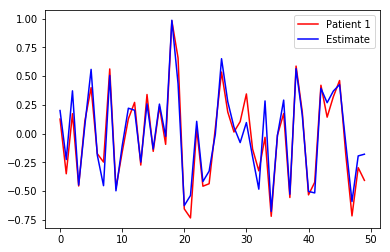

Eigenvalue =  114.147964421
Patient =  4
Avg abs error per feature:  0.120684706686


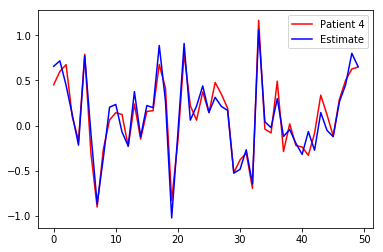

Eigenvalue =  133.81738641
Patient =  3
Avg abs error per feature:  0.0840872392384


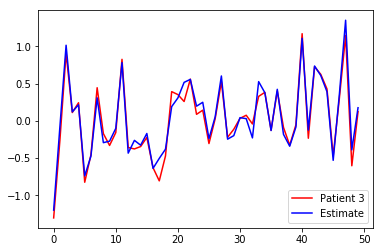

Eigenvalue =  491.702518832
Patient =  2
Avg abs error per feature:  0.0592513894298


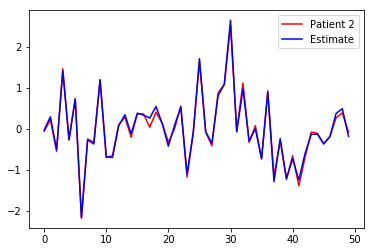

Eigenvalue =  767.973602342
Patient =  0
Avg abs error per feature:  0.0511016939243


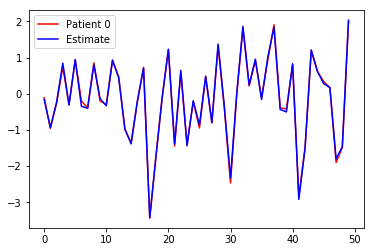

In [7]:
# random sample of features for graphs
sample=np.random.choice(range(nfeatures),np.min((nfeatures, 50)), replace=False)
fig=0

# for each non-zero Eigenvalue of the correlation matrix
for i in range(nfeatures-npatients, nfeatures):
    print("Eigenvalue = ", W[i])
    # find closest data vector x - we can have estimate~= x or estimate~= -x 
    diff=np.empty((npatients, 2))
    diff[:,0]=np.linalg.norm(X-V[i,:], axis=1, ord=1) # L1 norm; L2 also works
    diff[:,1]=np.linalg.norm(X+V[i,:], axis=1, ord=1)
    diff=diff/nfeatures # avg absolute error per feature
    patient=np.argmin(np.min(diff, axis=1))
    print ("Patient = ", patient)
    if diff[patient, 0]> diff[patient, 1]:
        V[i,:]=-V[i,:]
        print("Avg abs error per feature: ", diff[patient,1])
    else:
        print("Avg abs error per feature: ", diff[patient,0])
    figure=plt.figure(fig)
    plt.plot(X[patient,sample], 'r', label="Patient {}".format(patient))
    plt.plot(V[i,sample], 'b', label="Estimate")
    ax=figure.axes
    ax[0].legend()
    plt.show()
    fig+=1
        
    

As can be seen, data can be reconstructed with good approximation up to a sign. 

# A note on rotations

You rightly point out that the correlation $C=X^tX$ is invariant if the rows of $X$ are linearly combined with a unitary matrix, since if $X\prime=AX$, then $C\prime=(X^tA^t)(AX)=X^t(A^tA)X=C$. This begs the question of why the original data rows are reconstructed (instead of any such linear combination). I believe the answer is obtained by looking at the matrix of the pairwise scalar products of the rows of $X$, that is the "wrong" correlation $Q=XX^t$. 

Let us, for a start, generate a random rotation matrix for the patients using the [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition#Computing_the_QR_decomposition):

In [8]:
A, _= np.linalg.qr(np.random.normal(loc=10, size=(npatients, npatients)))
print(np.allclose(A @ A.T, np.eye(npatients))) # A * A^t ~= Id
A

True


array([[-0.46105894,  0.39697212,  0.75579443, -0.24129559, -0.01972341],
       [-0.45449013, -0.5497288 ,  0.22250673,  0.66375312, -0.0340517 ],
       [-0.37195032,  0.66396409, -0.42746686,  0.44838792,  0.19241885],
       [-0.47106533, -0.07784962, -0.36267794, -0.30344066, -0.74055747],
       [-0.46969542, -0.3054546 , -0.25495556, -0.45615818,  0.6426516 ]])

We then have:

In [9]:
Q= X @ X.T
X1=A @ X
Q1=X1 @ X1.T
Q1.shape == Q.shape

True

We now observe that ```Q``` is very nearly diagonal, meaning that the rows of ```X``` are approximately orthogonal to each other. That random vectors in a high dimensional space have a high probability of being nearly orthogonal is a well known geometric effect, and is precisely the reason why we chose to work in the limit of high ```nfeatures``` (see Exercise 2.12 in [Flows](http://chaosbook.org/version16/chapters/flows.pdf), ChaosBook).

In [10]:
# all weight is on the diagonal - * is the componentwise product
np.linalg.norm (Q* np.eye(npatients))/np.linalg.norm(Q)

0.99784592834193342

However, the same is not true of $Q\prime$, at least not to the same extent:

In [11]:
np.linalg.norm (Q1* np.eye(npatients))/np.linalg.norm(Q1)

0.79257736562554482

In fact, $Q$ is **not** invariant under the action of $A$: $Q\prime=(AX)(AX)^t=A(XX^t)A^t= AQA^t$. Since $Q\prime$ is not diagonal, the rows of $X\prime$ are no longer orthogonal to each other.  This is counterintuitive, as we are talking about linear combinations of random row vectors with the coefficients of a random orthogonal matrix, so why are the results not, somehow, just as random as the original vectors? However, it is easy to see that even if $u$ and $v$ are orthogonal vectors, for example $u\prime=(\sqrt{2}/2\,u + \sqrt{2}/2\,v)$ and $v\prime= (\sqrt{2}/2\,u - \sqrt{2}/2\,v)$ (to use the coefficients of a two-dimensional 45-degrees rotation) are not themselves orthogonal to each other.

Thus the reason why the original matrix $X$ is reconstructed when we compute the principal axes of $C$ is as follows: of all the choices of $A$ yielding a set of data points $AX$ that share the same correlation matrix $C$ and therefore the same principal axes, the choice $A=\mathbb{1}$ is precisely that for which the data points themselves, being (nearly) orthogonal, coincide approximately with those principal axes.

In abstract terms, if we complete (the reconstructed) $X$ to an orthogonal basis for the ```nfeatures```-dimensional space, I believe we can see this is a consequence of the fact that given two symmetric bilinear forms, one of which is positive definite, there is a basis on which both forms are diagonal. In this case $C$ is one such form, while the other is the (positive definite) Euclidean metric. 

# Corrections to my notes sent on 27/5

I was wrong to state in point 1 in my notes that $C$ is already diagonal; however, as shown, its Eigenvectors are the data vectors. Also, in point 2 of my notes, $X^t X$ _**is**_ the correlation matrix and $XX^t=Q$ has no interest in that context. Apologies.

# Conclusions

In conclusion, I believe this example proves two facts:

* your concern is well founded, in that there is definitely potential for massive information leaks, at least in some situations;

* from the point of view of an attacker, the problem may sometimes be quite tractable (in this case, quadratic optimisation).  Efficient strategies are then available to the attacker, that make it harder for the node to detect the attack from the sheer number of queries.

(C) [Fabrizio Smeraldi](mailto:f.smeraldi@qmul.ac.uk), June 2020 - All rights reserved.